In [2]:
!pip install astra-toolbox

import astra
import numpy as np
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

def create_complex_binary_phantom(size=256):
  """Creates a complex binary phantom with diverse shapes.

  Args:
    size: The size of the square phantom (e.g., 256 for 256x256).

  Returns:
    A 2D numpy array representing the binary phantom.
  """
  phantom = np.zeros((size, size), dtype=np.uint8)

  # Add some simple shapes
  # Square
  phantom[int(size * 0.2):int(size * 0.4), int(size * 0.2):int(size * 0.4)] = 1
  # Circle
  center_x, center_y = int(size * 0.6), int(size * 0.3)
  radius = int(size * 0.15)
  y, x = np.ogrid[:size, :size]
  dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
  phantom[dist_from_center <= radius] = 1
  # Rectangle
  phantom[int(size * 0.7):int(size * 0.8), int(size * 0.5):int(size * 0.9)] = 1


  '''
  # Add more complex shapes using random walks or cellular automata for irregularity
  # This is a simplified example using random points and smoothing
  num_irregular_shapes = 3
  for _ in range(num_irregular_shapes):
    start_x, start_y = np.random.randint(0, size, 2)
    shape_size = np.random.randint(int(size * 0.05), int(size * 0.2))
    for i in range(shape_size):
        for j in range(shape_size):
            if np.random.rand() > 0.7: # Introduce some randomness
                x_offset, y_offset = np.random.randint(-5, 6, 2)
                nx, ny = start_x + i + x_offset, start_y + j + y_offset
                if 0 <= nx < size and 0 <= ny < size:
                    phantom[nx, ny] = 1
  '''
  # Optional: Apply a small smoothing filter to make the irregular shapes less blocky
  # from scipy.ndimage import gaussian_filter
  # phantom = gaussian_filter(phantom.astype(float), sigma=1.5) > 0.5

  return phantom.astype(np.uint8)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 8.4 MB/s eta 0:00:00


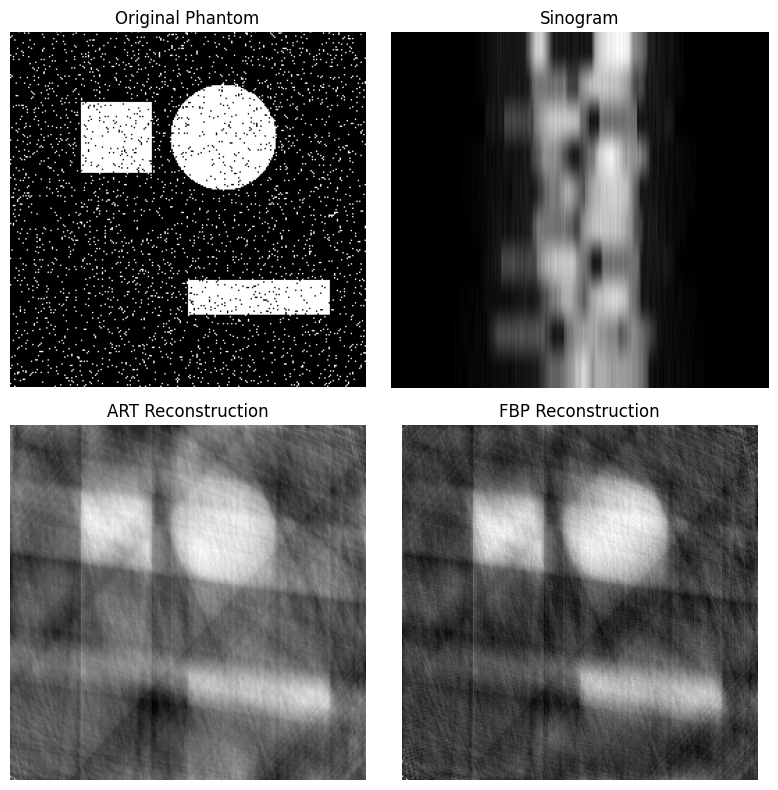

In [3]:
# Parameters
N = 128
M = int(2 ** np.ceil(np.log2(N * np.sqrt(2))))
angles = np.random.rand(10)*np.pi

# Create geometries
vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, M, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Generate sinogram using ASTRA
amount = 0.05
phantom = create_complex_binary_phantom(size=N)
salt = np.random.rand(N, N) < amount
pepper = np.random.rand(N, N) < amount
phantom[salt] = 1
phantom[pepper] = 0

phantom_id = astra.data2d.create('-vol', vol_geom, phantom)
sinogram_id, sinogram = astra.create_sino(phantom_id, proj_id)

# ART reconstruction (via ASTRA)
rec_id = astra.data2d.create('-vol', vol_geom, 0)
cfg = astra.astra_dict('SART')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 20)
rec_art = astra.data2d.get(rec_id)

# Custom FBP-like reconstruction using system matrix
matrix_id = astra.projector.matrix(proj_id)
W = astra.matrix.get(matrix_id)  # sparse matrix
rec_fbp = lsqr(W, sinogram.ravel())[0].reshape(N, N)

# Clean up ASTRA memory
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)
astra.matrix.delete(matrix_id)

# Return relevant data for further use
result = {
    "phantom": phantom,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
}

def plot_binary_tomography_results(
    refined, rec_fbp, loss_history,
    sino_target, synthetic_sinogram,
    sinogram_shape
):
    """
    refined: 2D np.array (binary reconstruction)
    rec_fbp: 2D np.array (initial FBP reconstruction)
    loss_history: list of float (error values)
    sino_target: 1D np.array (flattened target sinogram)
    synthetic_sinogram: 2D np.array (W @ refined)
    sinogram_shape: tuple (shape of sinogram for reshaping)
    """

    # --- 1x2: Loss history and final refined image ---
    plt.figure(figsize=(12, 5))

    # Loss history plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, marker='o', linestyle='-', markersize=3)
    plt.title('Loss Function Decrease', fontsize=14)
    plt.xlabel('Improvement Step', fontsize=12)
    plt.ylabel('Projection Error (L2 Norm)', fontsize=12)
    plt.grid(True)

    # Final binary image
    plt.subplot(1, 2, 2)
    plt.imshow(refined, cmap='binary', interpolation='none')
    plt.title('Refined Binary Image', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # --- 2x2: Comparison of reconstructions and sinograms ---
    plt.figure(figsize=(12, 10))

    # FBP reconstruction
    plt.subplot(2, 2, 1)
    plt.imshow(rec_fbp, cmap='gray', interpolation='none')
    plt.title('Original FBP Reconstruction', fontsize=14)
    plt.axis('off')

    # Refined binary reconstruction
    plt.subplot(2, 2, 2)
    plt.imshow(refined, cmap='binary', interpolation='none')
    plt.title('Refined Binary Reconstruction', fontsize=14)
    plt.axis('off')

    # Real sinogram
    plt.subplot(2, 2, 3)
    plt.imshow(sino_target.reshape(sinogram_shape), cmap='gray', aspect='auto')
    plt.title('Target (Real) Sinogram', fontsize=14)
    plt.xlabel('Detector Element', fontsize=12)
    plt.ylabel('Projection Angle', fontsize=12)
    plt.colorbar(label='Intensity')

    # Synthetic sinogram
    plt.subplot(2, 2, 4)
    plt.imshow(synthetic_sinogram, cmap='gray', aspect='auto')
    plt.title('Synthetic Sinogram from Refined Image', fontsize=14)
    plt.xlabel('Detector Element', fontsize=12)
    plt.ylabel('Projection Angle', fontsize=12)
    plt.colorbar(label='Intensity')

    plt.tight_layout()
    plt.show()

def plot_reconstruction_grid(phantom, sinogram, rec_art, rec_fbp):
    """
    Plot a 2x2 comparison grid:
    (0,0): Original phantom
    (0,1): Sinogram
    (1,0): ART reconstruction
    (1,1): FBP reconstruction
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.gray()

    axes[0, 0].imshow(phantom)
    axes[0, 0].set_title('Original Phantom')

    axes[0, 1].imshow(sinogram, aspect='auto')
    axes[0, 1].set_title('Sinogram')

    axes[1, 0].imshow(rec_art)
    axes[1, 0].set_title('SART Reconstruction')

    axes[1, 1].imshow(rec_fbp)
    axes[1, 1].set_title('FBP Reconstruction')

    for ax in axes.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_reconstruction_grid(
    result["phantom"],
    result["sinogram"],
    result["rec_art"],
    result["rec_fbp"]
)

Initial error: 582.692951


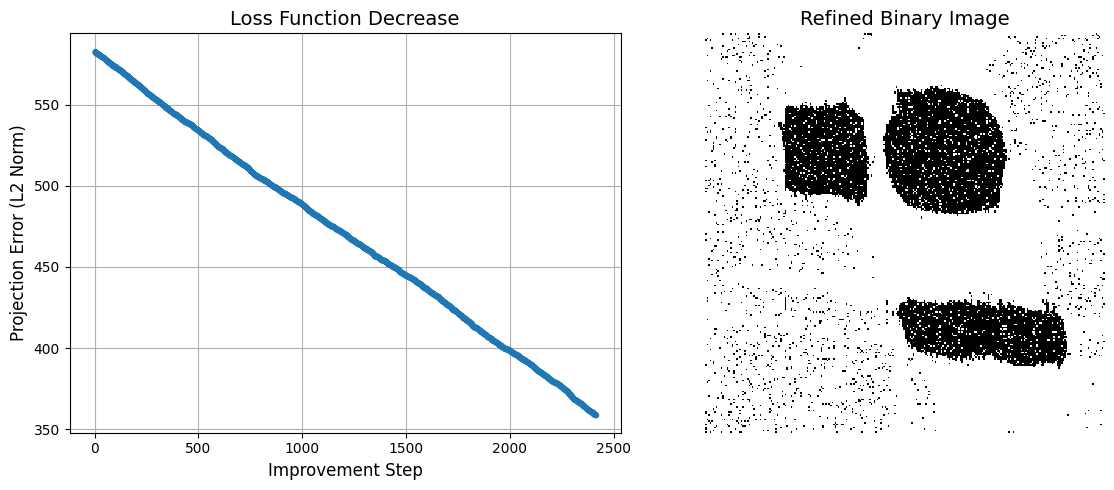

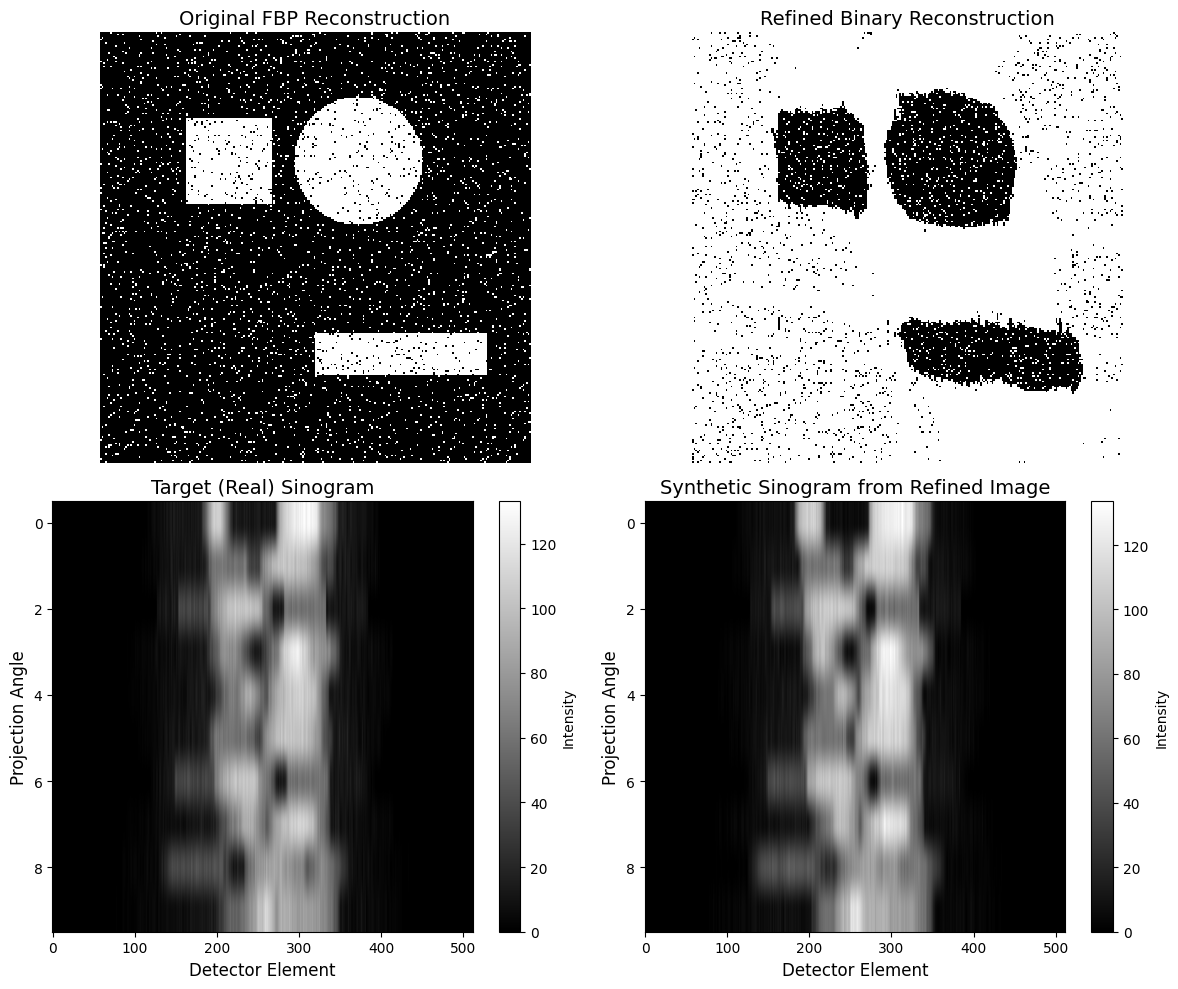

In [4]:
threshold = 0.5
max_iter = 5000
epsilon = 0.0005
verbose = False

W = result["system_matrix"]
sinogram = result["sinogram"]
sino_target = sinogram.ravel()
X_init = rec_fbp.ravel()
#Estimate area from sinograms
A = int(np.round(sum(sino_target)/len(angles)))

# take A most shiny pixels
X = np.zeros_like(X_init, dtype=np.uint8)
X[np.argsort(X_init)[-A:]] = 1

# L2, L1 whatever we want
def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target)

best_X = X.copy()
best_err = proj_error(X)
loss_history = [best_err] # To store loss values for plotting

print(f"Initial error: {best_err:.6f}")

# --- Binary Tomography Refinement Loop (Greedy Local Search) ---
for iteration in range(max_iter):
    idx = np.random.randint(0, N * N) # Choose a random pixel index
    X[idx] = 1 - X[idx]  # Flip the pixel (0 to 1, or 1 to 0)

    # Calculate error for the flipped image. This replaces proj_error(X)
    current_proj_error = np.linalg.norm(W @ X - sino_target)

    if current_proj_error < best_err:
        best_err = current_proj_error
        best_X = X.copy() # Store the image that yielded the better error
        loss_history.append(best_err) # Store improved loss
        if verbose:
            print(f"[{iteration}] Improved error: {best_err:.6f}")
        if best_err < epsilon:
            if verbose:
                print(f"Reached desired error < {epsilon} at iteration {iteration}")
            break # Stop if error is below epsilon
    else:
        X[idx] = 1 - X[idx]  # Revert the flip if it didn't improve the error

# Reshape the best binary image back to its original N x N dimensions
refined = best_X.reshape(N, N)

plot_binary_tomography_results(
    refined=refined,
    rec_fbp=phantom,
    loss_history=loss_history,
    sino_target=sino_target,
    synthetic_sinogram = (W @ refined.ravel()).reshape(sinogram.shape),
    sinogram_shape=sinogram.shape
)


Pass 1: 2991 pixels updated
Pass 2: 2907 pixels updated
Pass 3: 2870 pixels updated


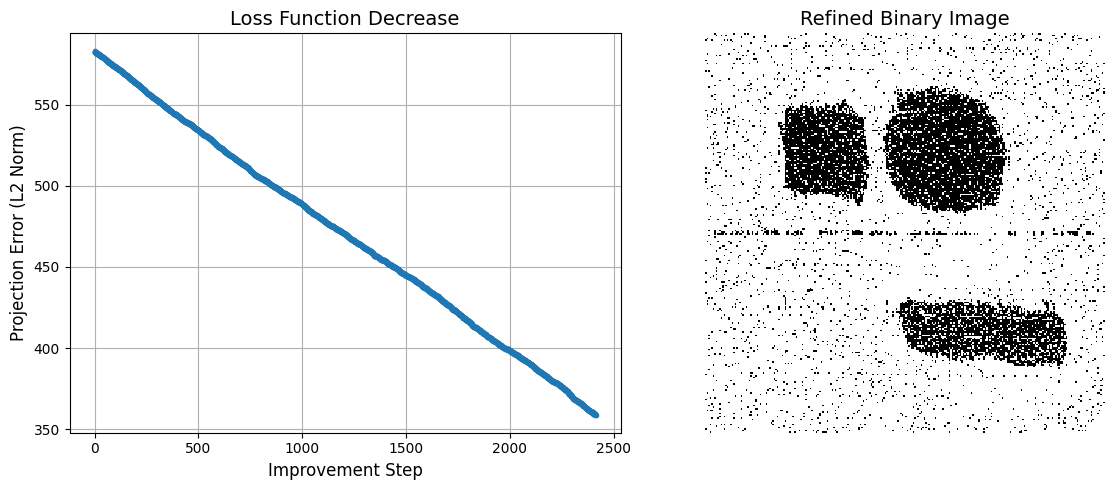

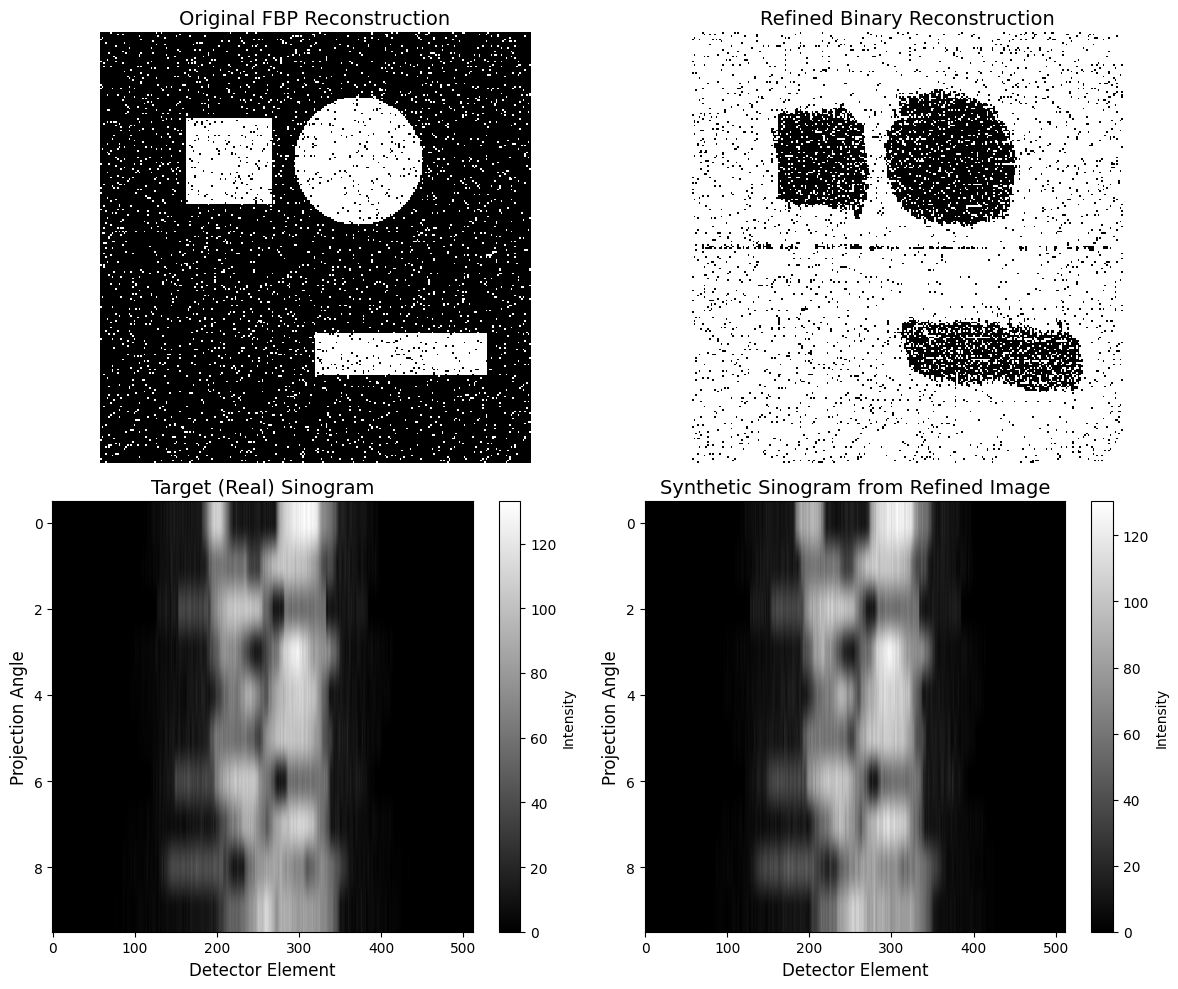

In [5]:
# --- Projection-by-projection binary refinement ---
X_init = rec_fbp.ravel()
A = int(np.round(sum(sino_target)/len(angles)))
X_bin = np.zeros_like(X_init, dtype=np.uint8)
X_bin[np.argsort(X_init)[-A:]] = 1
num_projs = W.shape[0]
epsilon_rel = 0.01  # 5% relative tolerance
max_passes = 3

num_projs = W.shape[0]
all_projection_indices = np.arange(num_projs)

for pass_idx in range(max_passes):
    changes = 0

    np.random.shuffle(all_projection_indices)

    for i in all_projection_indices:
        row = W.getrow(i)
        p_real = sino_target[i]
        p_sim = row @ X_bin
        diff = p_sim.item() - p_real

        if abs(diff) <= epsilon_rel * (abs(p_real) + 1e-8):
            continue  # already within tolerance

        # Pixels involved in this projection
        involved_pixels = row.indices
        if len(involved_pixels) == 0:
            continue  # skip empty rows

        if diff > 0:
            candidates = [j for j in involved_pixels if X_bin[j] == 1]
        else:
            candidates = [j for j in involved_pixels if X_bin[j] == 0]

        if len(candidates) == 0:
            continue

        # Greedy pick: one that reduces error the most
        best_j = None
        best_err = abs(diff)
        original_proj = p_sim.item()

        for j in candidates:
            X_bin[j] = 1 - X_bin[j]  # flip
            new_proj = row @ X_bin
            new_err = abs(new_proj.item() - p_real)
            if new_err < best_err:
                best_j = j
                best_err = new_err
            X_bin[j] = 1 - X_bin[j]  # revert

        if best_j is not None and best_err < abs(diff):
            X_bin[best_j] = 1 - X_bin[best_j]
            changes += 1

    print(f"Pass {pass_idx+1}: {changes} pixels updated")
    if changes == 0:
        break  # converged

# Final image
refined = X_bin.reshape(N, N)

# Visualization
plot_binary_tomography_results(
    refined=refined,
    rec_fbp=phantom,
    loss_history=loss_history,
    sino_target=sino_target,
    synthetic_sinogram=(W @ refined.ravel()).reshape(sinogram.shape),
    sinogram_shape=sinogram.shape
)


Initial A (number of 'on' pixels to target): 11185
Initial error: 480.358117


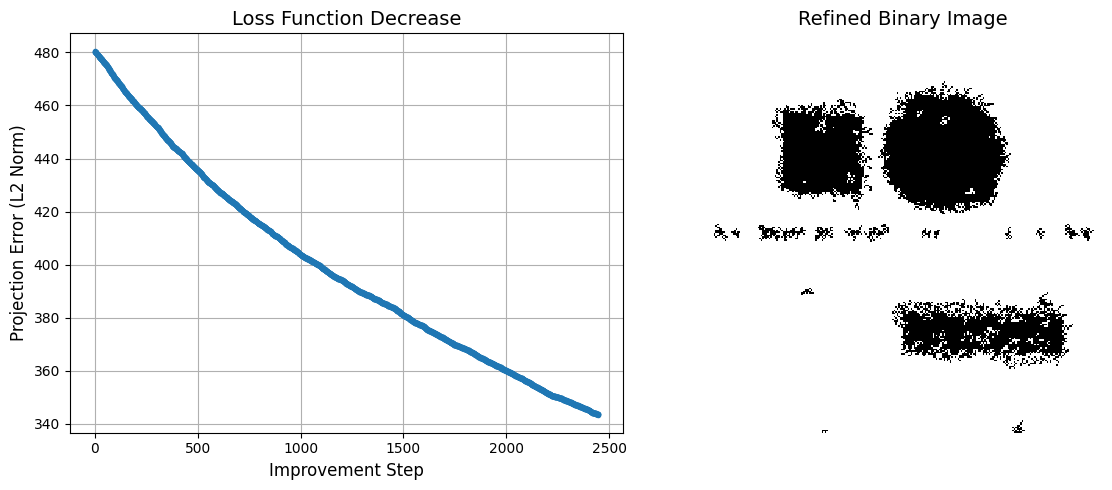

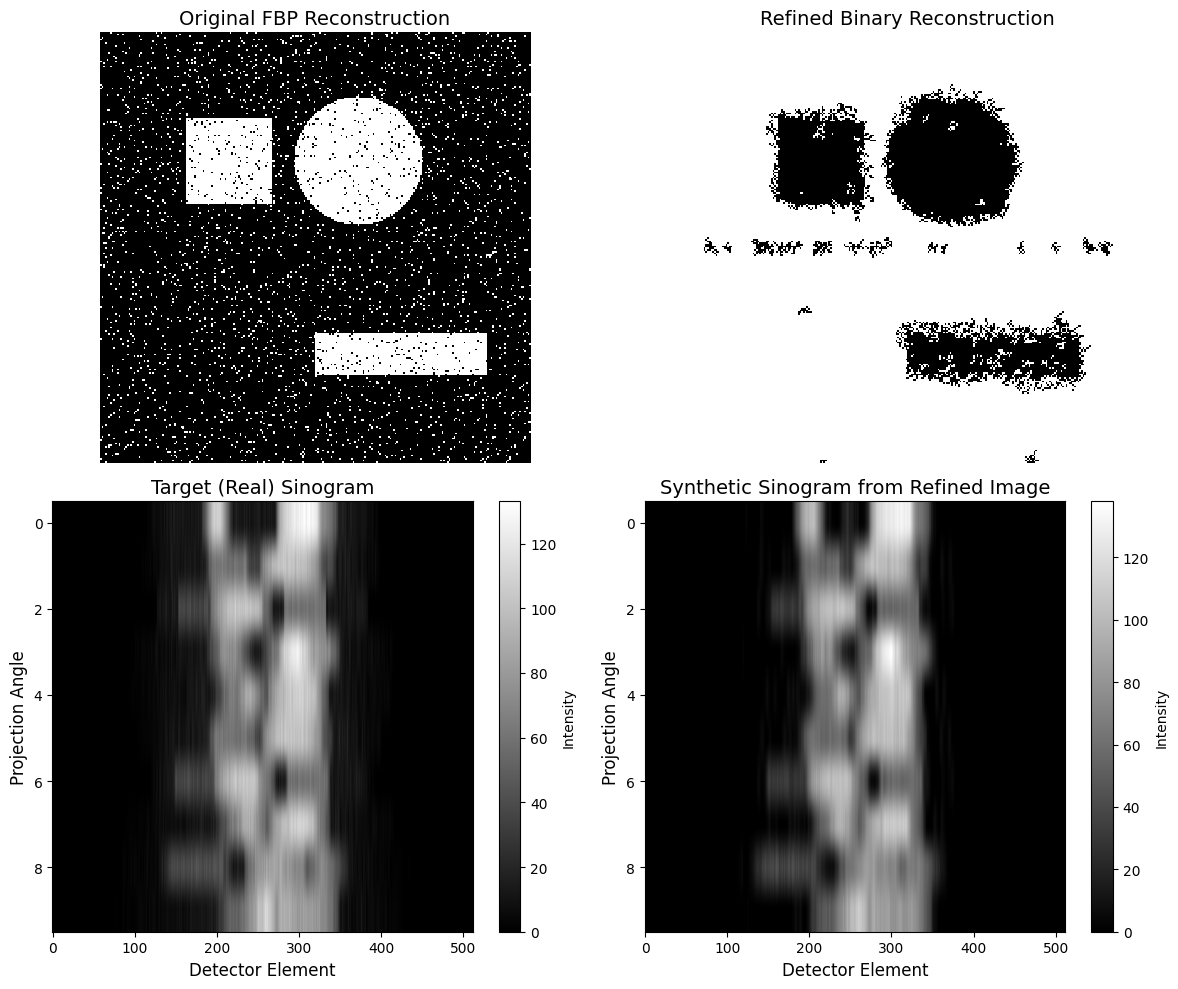

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage import median_filter, binary_opening, generate_binary_structure


threshold = 0.5
max_iter = 5000
epsilon = 0.005
verbose = False # Set to True to see iteration updates

# Ensure W is correctly shaped for matrix multiplication with flattened X
if W.shape[1] != N * N:
    print(f"Warning: W.shape[1] ({W.shape[1]}) does not match N*N ({N*N}). Adjusting N or W accordingly.")
    # Attempt to infer N from W if it's the 2nd dimension
    N_inferred = int(np.sqrt(W.shape[1]))
    if N_inferred * N_inferred == W.shape[1]:
        N = N_inferred
        print(f"N inferred as {N} from W.shape[1].")
    else:
        raise ValueError("Cannot infer N from W.shape[1]. Please ensure N is correctly set for your image dimensions.")

sinogram = result["sinogram"]
sino_target = sinogram.ravel()

rec_fbp = refined# result["rec_fbp"]
rec_fbp = median_filter(rec_fbp, size=3)
X_init = rec_fbp.ravel()

# Calculate 'A' based on the FBP image, representing the approximate number of 'on' pixels
# This is a critical step for initializing X
A = int(np.round(np.sum(X_init > threshold))) # Count pixels above threshold in FBP as 'on'
print(f"Initial A (number of 'on' pixels to target): {A}")


# Define sampling distribution from FBP (still useful as a fallback or for initial sampling bias)
fbp_flat = rec_fbp.ravel().astype(np.float64)
uncertainty = 1.0 - np.abs(fbp_flat - 0.5) * 2  # maps [0,1] to [1,0], max at 0.5
uncertainty = np.clip(uncertainty, 0, 1) + 1e-6
prob_weights = uncertainty / uncertainty.sum()



X = np.zeros_like(X_init, dtype=np.uint8)
# Initialize X by setting the 'A' brightest pixels from FBP to 1
# This gives a better starting point than random or all zeros.
X[np.argsort(X_init)[-A:]] = 1

def proj_error(x_bin):
    """Calculates the L2 norm of the difference between actual and synthetic sinogram."""
    return np.linalg.norm(W @ x_bin - sino_target)

best_X = X.copy()
best_err = proj_error(X)
loss_history = [best_err] # To store loss values for plotting

print(f"Initial error: {best_err:.6f}")

# --- Binary Tomography Refinement Loop (Greedy Local Search with Boundary Sampling) ---
boundary_recalc_freq = 100 # Recalculate boundary pixels every N iterations
current_boundary_indices = []

for iteration in range(max_iter):

    # Periodically update boundary pixels
    if iteration % boundary_recalc_freq == 0:
        X_2d = X.reshape(N, N)

        # Efficient boundary detection using scipy.ndimage
        # A pixel is on the boundary if its value is different from any of its neighbors.
        # This can be found by (dilated_image XOR eroded_image)
        # Using a 3x3 square structuring element for 8-connectivity check
        selem = np.ones((3, 3), dtype=bool)

        eroded_X = binary_erosion(X_2d, structure=selem)
        dilated_X = binary_dilation(X_2d, structure=selem)

        # Pixels that are different in erosion or dilation are boundary candidates
        boundary_mask = (X_2d != eroded_X) | (X_2d != dilated_X)

        temp_boundary_indices = np.where(boundary_mask.ravel())[0].tolist()

        if len(temp_boundary_indices) > 0:
            current_boundary_indices = temp_boundary_indices
        else:
            # Fallback: if no clear boundary (e.g., image is all 0s or all 1s),
            # revert to FBP-weighted sampling or all pixels
            current_boundary_indices = np.random.choice(len(X), p=prob_weights, size=int(len(X)*0.1)).tolist() # sample 10% randomly
            if verbose:
                print(f"[{iteration}] No clear boundary found, falling back to random FBP-weighted sampling for this phase.")


    if len(current_boundary_indices) > 0:
        idx = np.random.choice(current_boundary_indices)
    else:
        # Should be covered by the fallback above, but as a safeguard
        idx = np.random.choice(len(X), p=prob_weights) # Fallback to FBP weights if somehow empty


    X[idx] = 1 - X[idx]  # Flip the pixel (0 to 1, or 1 to 0)

    # Calculate error for the flipped image.
    current_proj_error = proj_error(X) # Use the defined function for clarity

    if current_proj_error < best_err:
        best_err = current_proj_error
        best_X = X.copy() # Store the image that yielded the better error
        loss_history.append(best_err) # Store improved loss
        if verbose:
            print(f"[{iteration}] Improved error: {best_err:.6f}")
        if best_err < epsilon:
            if verbose:
                print(f"Reached desired error < {epsilon} at iteration {iteration}")
            break # Stop if error is below epsilon
    else:
        X[idx] = 1 - X[idx]  # Revert the flip if it didn't improve the error

# Reshape the best binary image back to its original N x N dimensions
refined = best_X.reshape(N, N)

plot_binary_tomography_results(
    refined=refined,
    rec_fbp=phantom,
    loss_history=loss_history,
    sino_target=sino_target,
    synthetic_sinogram = (W @ refined.ravel()).reshape(sinogram.shape),
    sinogram_shape=sinogram.shape
)

Initial A (number of 'on' pixels to target): 9655
Initial total loss: 1098.034321


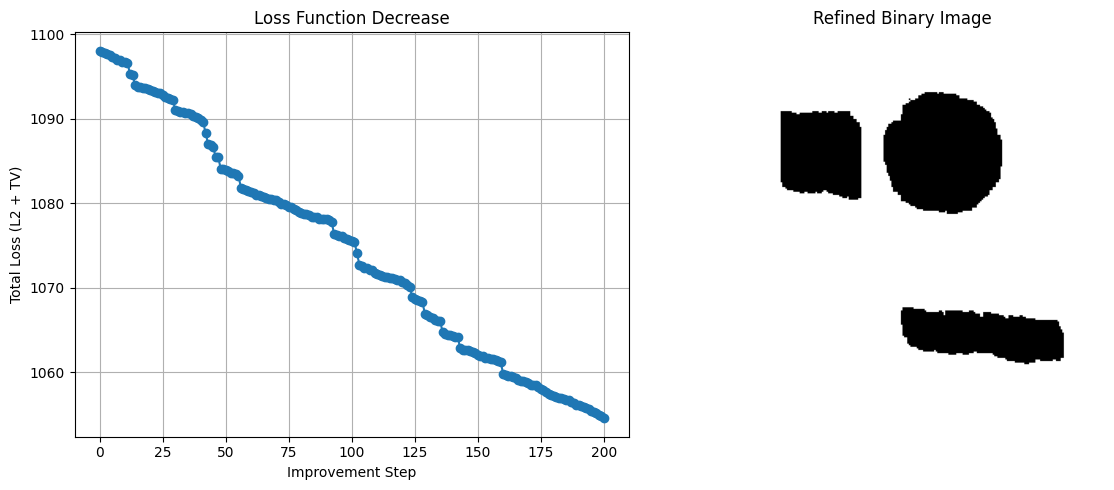

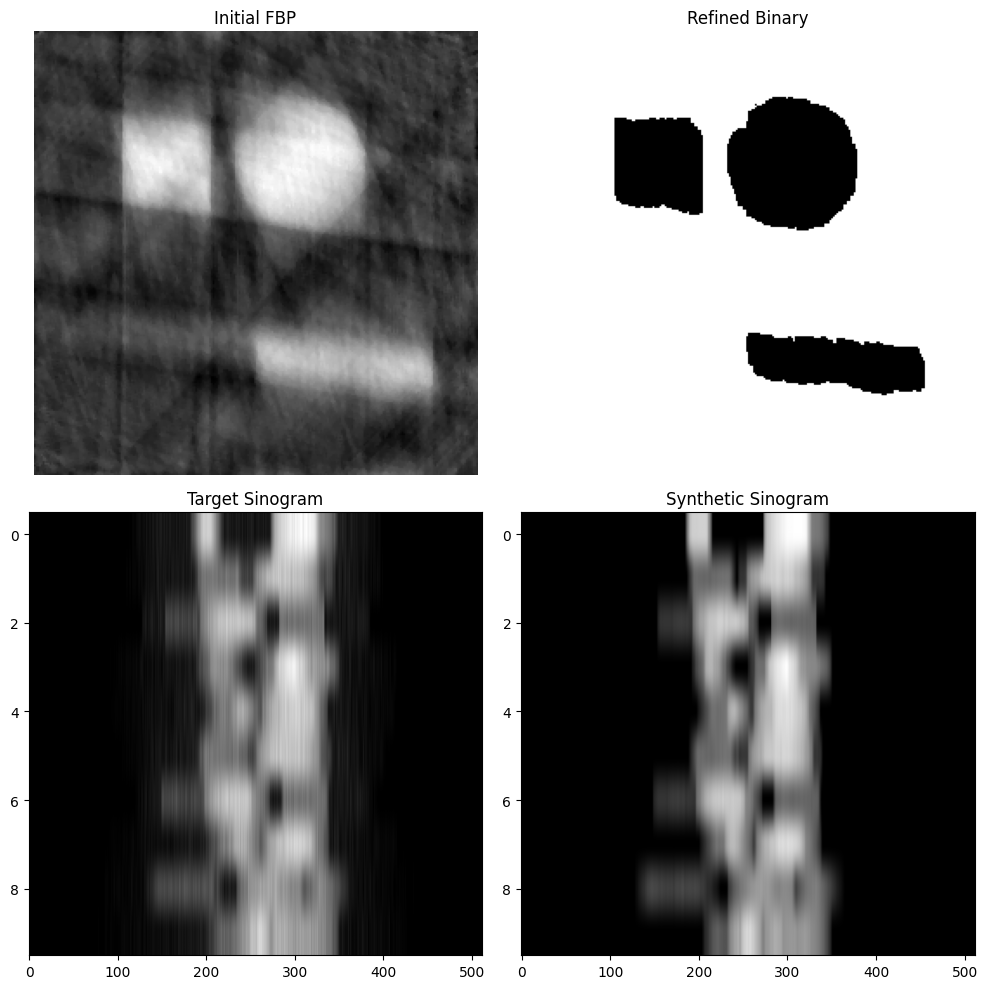

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation, median_filter
from scipy.ndimage import convolve

# --- PARAMETERS ---
threshold = 0.5
max_iter = 2000
# --- INITIALIZATION ---
sinogram = result["sinogram"]
sino_target = sinogram.ravel()

rec_fbp = median_filter(result["rec_fbp"], size=3)
X_init = rec_fbp.ravel()

A = int(np.round(np.sum(X_init > threshold)))
print(f"Initial A (number of 'on' pixels to target): {A}")

fbp_flat = rec_fbp.ravel().astype(np.float64)
uncertainty = 1.0 - np.abs(fbp_flat - 0.5) * 2  # maps [0,1] to [1,0], max at 0.5
uncertainty = np.clip(uncertainty, 0, 1) + 1e-6
prob_weights = uncertainty / uncertainty.sum()


X = np.zeros_like(X_init, dtype=np.uint8)
X[np.argsort(X_init)[-A:]] = 1

# --- ERROR + REGULARIZATION ---
def proj_error(x_bin):
    return np.linalg.norm(W @ x_bin - sino_target)

def total_variation(x_bin):
    x_2d = x_bin.reshape(N, N)
    gx = np.abs(np.diff(x_2d, axis=1)).sum()
    gy = np.abs(np.diff(x_2d, axis=0)).sum()
    return gx + gy

def total_loss(x_bin):
    return proj_error(x_bin) + lambda_tv * total_variation(x_bin)

# --- MAIN OPTIMIZATION ---
lambda_tv = 0.005
best_X = X.copy()
best_err = total_loss(X)
loss_history = [best_err]
print(f"Initial total loss: {best_err:.6f}")

current_boundary_indices = []

for iteration in range(max_iter):
    if iteration % boundary_recalc_freq == 0:
        X_2d = X.reshape(N, N)
        selem = np.ones((3, 3), dtype=bool)
        eroded = binary_erosion(X_2d, structure=selem)
        dilated = binary_dilation(X_2d, structure=selem)
        boundary_mask = (X_2d != eroded) | (X_2d != dilated)
        temp_boundary_indices = np.where(boundary_mask.ravel())[0].tolist()

        if len(temp_boundary_indices) > 0:
            current_boundary_indices = temp_boundary_indices
        else:
            current_boundary_indices = np.random.choice(len(X), p=prob_weights, size=int(len(X)*0.1)).tolist()
            if verbose:
                print(f"[{iteration}] No boundary found, using fallback sampling.")

    idx = np.random.choice(current_boundary_indices)
    X[idx] = 1 - X[idx]
    current_loss = total_loss(X)

    if current_loss < best_err:
        best_err = current_loss
        best_X = X.copy()
        loss_history.append(best_err)
        if verbose:
            print(f"[{iteration}] Improved total loss: {best_err:.6f}")
        if best_err < epsilon:
            print(f"Reached epsilon threshold at iteration {iteration}")
            break
    else:
        X[idx] = 1 - X[idx]  # revert

refined = best_X.reshape(N, N)

# --- VISUALIZATION FUNCTION ---
def plot_binary_tomography_results(refined, rec_fbp, loss_history, sino_target, synthetic_sinogram, sinogram_shape):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(loss_history, marker='o', linestyle='-')
    axs[0].set_title('Loss Function Decrease')
    axs[0].set_xlabel('Improvement Step')
    axs[0].set_ylabel('Total Loss (L2 + TV)')
    axs[0].grid(True)

    axs[1].imshow(refined, cmap='binary')
    axs[1].set_title('Refined Binary Image')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0, 0].imshow(rec_fbp, cmap='gray')
    axs[0, 0].set_title("Initial FBP")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(refined, cmap='binary')
    axs[0, 1].set_title("Refined Binary")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(sino_target.reshape(sinogram_shape), cmap='gray', aspect='auto')
    axs[1, 0].set_title("Target Sinogram")
    axs[1, 0].axis('on')

    axs[1, 1].imshow(synthetic_sinogram, cmap='gray', aspect='auto')
    axs[1, 1].set_title("Synthetic Sinogram")
    axs[1, 1].axis('on')

    plt.tight_layout()
    plt.show()

# --- FINAL VISUALIZATION ---
plot_binary_tomography_results(
    refined=refined,
    rec_fbp=rec_fbp,
    loss_history=loss_history,
    sino_target=sino_target,
    synthetic_sinogram=(W @ refined.ravel()).reshape(sinogram.shape),
    sinogram_shape=sinogram.shape
)
